In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')
import pickle # Import pickle

In [ ]:
# ============================================================================
# STEP 1: LOAD DATA FROM CSV
# ============================================================================

def load_data(csv_path):
    """
    Load PM2.5 data from CSV file.

    Expected columns: location_id, location_name, parameter, value,
                      datetimeUtc, latitude, longitude

    MINIMUM DATA REQUIRED: 72 hours (3 days) for meaningful training
    """
    print("="*70)
    print("LOADING DATA")
    print("="*70)

    df = pd.read_csv(csv_path)

    # Convert datetime
    df['datetime'] = pd.to_datetime(df['datetimeUtc'])

    # Sort by datetime
    df = df.sort_values('datetime').reset_index(drop=True)

    # Extract key info
    location_name = df['location_name'].iloc[0]
    n_hours = len(df)
    date_range = f"{df['datetime'].min()} to {df['datetime'].max()}"

    print(f"\nLocation: {location_name}")
    print(f"Data points: {n_hours} hours")
    print(f"Date range: {date_range}")
    print(f"Parameter: {df['parameter'].unique()}")

    # Check minimum data requirement
    if n_hours < 72:
        print(f"\n{'='*70}")
        print("⚠️  WARNING: INSUFFICIENT DATA")
        print(f"{'='*70}")
        print(f"You have: {n_hours} hours of data")
        print(f"Minimum required: 72 hours (3 days)")
        print(f"\nWhy? With 24h lookback + 24h forecast:")
        print(f"  - First 24h lost (no historical data for features)")
        print(f"  - Last 24h lost (no future data for targets)")
        print(f"  - Need 24h+ for train/test = 72h minimum")
        print(f"\nRecommended: 168+ hours (7 days) for good accuracy")
        print(f"{'='*70}")
        raise ValueError(f"Need at least 72 hours of data, got {n_hours} hours")

    # Keep only needed columns
    df = df[['datetime', 'value']].copy()
    df.columns = ['datetime', 'pm25']

    print(f"\n✓ Data validation passed")
    print(f"\nData preview:")
    print(df.head())

    return df, location_name

In [ ]:
# ============================================================================
# STEP 2: FEATURE ENGINEERING
# ============================================================================

def create_features(df, lookback_hours=24, forecast_hours=24):
    """
    Create features for time series forecasting.

    Args:
        df: DataFrame with 'datetime' and 'pm25' columns
        lookback_hours: How many hours of past data to use as features
        forecast_hours: How many hours ahead to predict
    """
    print("\n" + "="*70)
    print("FEATURE ENGINEERING")
    print("="*70)

    df = df.copy()

    # 1. Temporal features
    df['hour'] = df['datetime'].dt.hour
    df['day_of_week'] = df['datetime'].dt.dayofweek
    df['day_of_month'] = df['datetime'].dt.day
    df['month'] = df['datetime'].dt.month
    df['is_weekend'] = (df['day_of_week'] >= 5).astype(int)

    # Cyclical encoding for hour
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)

    print(f"\n1. Created temporal features")

    # 2. Lag features (past values)
    lag_hours = [1, 2, 3, 6, 12] # Adjusted lag_hours
    for lag in lag_hours:
        df[f'pm25_lag_{lag}h'] = df['pm25'].shift(lag)

    print(f"2. Created lag features: {lag_hours}")

    # 3. Rolling statistics
    for window in [3, 6, 12]: # Adjusted rolling window
        df[f'pm25_rolling_mean_{window}h'] = df['pm25'].shift(1).rolling(window).mean()
        df[f'pm25_rolling_std_{window}h'] = df['pm25'].shift(1).rolling(window).std()

    print(f"3. Created rolling statistics: [3, 6, 12] hour windows")

    # 4. Target variables (future values)
    for h in range(1, forecast_hours + 1):
        df[f'pm25_target_{h}h'] = df['pm25'].shift(-h)

    print(f"4. Created {forecast_hours} target variables (1h to {forecast_hours}h ahead)")

    # 5. Remove rows with NaN
    print(f"\n5. Removing incomplete rows...")
    print(f"   Before: {len(df)} rows")

    # Calculate the minimum number of required historical data points
    min_historical_data = max(lag_hours + [window for window in [3, 6, 12]]) # Adjusted based on lag_hours and rolling window

    df = df.dropna()

    print(f"   After: {len(df)} rows")
    print(f"   (Removed first {min_historical_data} and last {forecast_hours} hours)") # Adjusted print statement

    return df

In [ ]:
# ============================================================================
# STEP 3: TRAIN/TEST SPLIT
# ============================================================================

def split_data(df, test_hours=24, forecast_hours=24):
    """
    Split data into train/test sets temporally.

    Args:
        df: Featured dataframe
        test_hours: Number of hours to reserve for testing
        forecast_hours: How many hours ahead we're predicting
    """
    print("\n" + "="*70)
    print("TRAIN/TEST SPLIT")
    print("="*70)

    # Feature columns
    feature_cols = [col for col in df.columns if col not in
                   ['datetime', 'pm25'] and not col.startswith('pm25_target_')]

    # Target columns
    target_cols = [col for col in df.columns if col.startswith('pm25_target_')]

    # Split temporally
    split_idx = len(df) - test_hours

    if split_idx <= 0:
        raise ValueError("Not enough data for the specified test_hours.")

    X_train = df.iloc[:split_idx][feature_cols]
    y_train = df.iloc[:split_idx][target_cols]

    X_test = df.iloc[split_idx:][feature_cols]
    y_test = df.iloc[split_idx:][target_cols]

    dates_train = df.iloc[:split_idx]['datetime']
    dates_test = df.iloc[split_idx:]['datetime']

    print(f"\nFeatures: {len(feature_cols)} columns")
    print(f"Targets: {len(target_cols)} columns (1h to {forecast_hours}h ahead)")
    print(f"\nTrain set: {len(X_train)} samples")
    print(f"  Date range: {dates_train.min()} to {dates_train.max()}")
    print(f"\nTest set: {len(X_test)} samples")
    print(f"  Date range: {dates_test.min()} to {dates_test.max()}")

    return X_train, X_test, y_train, y_test, dates_test, feature_cols, target_cols


In [ ]:
# ============================================================================
# STEP 4: TRAIN MODEL
# ============================================================================

def train_model(X_train, y_train):
    """
    Train Random Forest model for multi-output forecasting.
    """
    print("\n" + "="*70)
    print("TRAINING MODEL")
    print("="*70)

    print("\nTraining Random Forest...")
    print("(This may take 1-2 minutes...)")

    model = RandomForestRegressor(
        n_estimators=100,
        max_depth=15,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42,
        n_jobs=-1
    )

    model.fit(X_train, y_train)

    print("✓ Training complete!")

    return model

In [ ]:
# ============================================================================
# STEP 5: EVALUATE MODEL
# ============================================================================

def evaluate_model(model, X_test, y_test):
    """
    Evaluate model performance on test set.
    """
    print("\n" + "="*70)
    print("MODEL EVALUATION")
    print("="*70)

    # Make predictions
    y_pred = model.predict(X_test)

    # Calculate metrics for different forecast horizons
    horizons = [1, 6] # Adjusted horizons

    print("\nPerformance by forecast horizon:")
    print("-" * 70)
    print(f"{'Horizon':<15} {'MAE':<12} {'RMSE':<12} {'R²':<12}")
    print("-" * 70)

    for h in horizons:
        if h <= y_test.shape[1]:
            y_true_h = y_test.iloc[:, h-1].values
            y_pred_h = y_pred[:, h-1]

            mae = mean_absolute_error(y_true_h, y_pred_h)
            rmse = np.sqrt(mean_squared_error(y_true_h, y_pred_h))
            r2 = r2_score(y_true_h, y_pred_h)

            print(f"{h}h ahead      {mae:>10.3f}  {rmse:>10.3f}  {r2:>10.3f}")

    # Overall metrics (all horizons)
    mae_overall = mean_absolute_error(y_test.values.flatten(), y_pred.flatten())
    rmse_overall = np.sqrt(mean_squared_error(y_test.values.flatten(), y_pred.flatten()))
    r2_overall = r2_score(y_test.values.flatten(), y_pred.flatten())

    print("-" * 70)
    print(f"{'Overall':<15} {mae_overall:>10.3f}  {rmse_overall:>10.3f}  {r2_overall:>10.3f}")
    print("-" * 70)

    return y_pred

In [ ]:
# ============================================================================
# STEP 6: VISUALIZE RESULTS
# ============================================================================

def visualize_last_24h(dates_test, y_test, y_pred, location_name):
    """
    Visualize actual vs predicted for last 24 hours (1-hour ahead predictions).
    """
    print("\n" + "="*70)
    print("VISUALIZATION: LAST 24 HOURS (1-hour ahead)")
    print("="*70)

    # Get 1-hour ahead predictions
    actual_1h = y_test.iloc[:, 0].values
    pred_1h = y_pred[:, 0]

    fig, ax = plt.subplots(figsize=(14, 5))

    ax.plot(dates_test, actual_1h, 'o-', label='Actual',
            color='blue', linewidth=2, markersize=6, alpha=0.7)
    ax.plot(dates_test, pred_1h, 's--', label='Predicted (1h ahead)',
            color='red', linewidth=2, markersize=5, alpha=0.7)

    # Calculate metrics
    mae = mean_absolute_error(actual_1h, pred_1h)
    rmse = np.sqrt(mean_squared_error(actual_1h, pred_1h))
    r2 = r2_score(actual_1h, pred_1h)

    ax.set_title(f'{location_name} - Last {len(dates_test)} Hours (1-hour ahead)\n' + # Adjusted title
                f'MAE: {mae:.2f} µg/m³, RMSE: {rmse:.2f} µg/m³, R²: {r2:.3f}',
                fontsize=13, fontweight='bold')

    ax.set_xlabel('Date & Time', fontsize=11)
    ax.set_ylabel('PM2.5 (µg/m³)', fontsize=11)
    ax.legend(loc='best', fontsize=10)
    ax.grid(True, alpha=0.3)

    # Format x-axis
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M'))
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')

    plt.tight_layout()
    plt.show()

    print("✓ Visualization complete")


def visualize_forecast_horizon(dates_test, y_test, y_pred, location_name):
    """
    Visualize how prediction accuracy changes over 24-hour forecast.
    Uses first test point to show full 24-hour forecast.
    """
    print("\n" + "="*70)
    print("VISUALIZATION: FORECAST HORIZON") # Adjusted title
    print("="*70)

    # Use first test point
    forecast_start = dates_test.iloc[0]
    actual_forecast = y_test.iloc[0].values # Adjusted variable name
    pred_forecast = y_pred[0] # Adjusted variable name

    hours = np.arange(1, len(actual_forecast) + 1) # Adjusted based on forecast_hours

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8))

    # Top plot: Actual vs Predicted
    ax1.plot(hours, actual_forecast, 'o-', label='Actual', # Adjusted variable name
            color='blue', linewidth=2, markersize=6, alpha=0.7)
    ax1.plot(hours, pred_forecast, 's--', label='Predicted', # Adjusted variable name
            color='red', linewidth=2, markersize=5, alpha=0.7)

    ax1.set_title(f'{location_name} - {len(actual_forecast)}-Hour Forecast\n' + # Adjusted title
                 f'Starting: {forecast_start.strftime("%Y-%m-%d %H:%M")}',
                 fontsize=13, fontweight='bold')
    ax1.set_xlabel('Forecast Hour', fontsize=11)
    ax1.set_ylabel('PM2.5 (µg/m³)', fontsize=11)
    ax1.legend(loc='best', fontsize=10)
    ax1.grid(True, alpha=0.3)

    # Bottom plot: Prediction Error over time
    errors = np.abs(actual_forecast - pred_forecast) # Adjusted variable name
    ax2.bar(hours, errors, color='orange', alpha=0.6, label='Absolute Error')
    ax2.axhline(y=np.mean(errors), color='red', linestyle='--',
               linewidth=2, label=f'Mean Error: {np.mean(errors):.2f}')

    ax2.set_title('Forecast Error by Hour', fontsize=12, fontweight='bold')
    ax2.set_xlabel('Forecast Hour', fontsize=11)
    ax2.set_ylabel('Absolute Error (µg/m³)', fontsize=11)
    ax2.legend(loc='best', fontsize=10)
    ax2.grid(True, alpha=0.3, axis='y')

    plt.tight_layout()
    plt.show()

    print("✓ Visualization complete")

In [ ]:

# ============================================================================
# STEP 7: MAKE PREDICTION FOR NEW DATA
# ============================================================================

def predict_next_24h(model, df, feature_cols):
    """
    Make 24-hour forecast using the latest data point.
    """
    print("\n" + "="*70)
    print("PREDICTING NEXT 24 HOURS")
    print("="*70)

    # Get latest complete data point
    latest = df.iloc[[-1]]
    latest_time = latest['datetime'].values[0]

    print(f"\nUsing data up to: {pd.Timestamp(latest_time).strftime('%Y-%m-%d %H:%M')}")

    # Extract features
    X_latest = latest[feature_cols]

    # Make prediction
    forecast = model.predict(X_latest)[0]

    # Create future timestamps
    future_times = pd.date_range(
        start=latest_time + pd.Timedelta(hours=1),
        periods=len(forecast), # Adjusted periods
        freq='H'
    )

    # Display forecast
    print("\n24-Hour Forecast:")
    print("-" * 50)
    print(f"{'Time':<20} {'Predicted PM2.5 (µg/m³)':<25}")
    print("-" * 50)

    for time, value in zip(future_times, forecast):
        print(f"{time.strftime('%Y-%m-%d %H:%M'):<20} {value:>20.2f}")

    print("-" * 50)
    print(f"{'Average':<20} {np.mean(forecast):>20.2f}")
    print(f"{'Min':<20} {np.min(forecast):>20.2f}")
    print(f"{'Max':<20} {np.max(forecast):>20.2f}")

    return future_times, forecast



                    PM2.5 FORECASTING PIPELINE
LOADING DATA

Location: Las Cruces ED
Data points: 120 hours
Date range: 2025-09-30 01:00:00+00:00 to 2025-10-05 00:00:00+00:00
Parameter: ['pm25']

✓ Data validation passed

Data preview:
                   datetime  pm25
0 2025-09-30 01:00:00+00:00   2.7
1 2025-09-30 02:00:00+00:00  -0.2
2 2025-09-30 03:00:00+00:00   2.5
3 2025-09-30 04:00:00+00:00   1.8
4 2025-09-30 05:00:00+00:00  -2.2

FEATURE ENGINEERING

1. Created temporal features
2. Created lag features: [1, 2, 3, 6, 12]
3. Created rolling statistics: [3, 6, 12] hour windows
4. Created 6 target variables (1h to 6h ahead)

5. Removing incomplete rows...
   Before: 120 rows
   After: 102 rows
   (Removed first 12 and last 6 hours)

TRAIN/TEST SPLIT

Features: 18 columns
Targets: 6 columns (1h to 6h ahead)

Train set: 96 samples
  Date range: 2025-09-30 13:00:00+00:00 to 2025-10-04 12:00:00+00:00

Test set: 6 samples
  Date range: 2025-10-04 13:00:00+00:00 to 2025-10-04 18:00:00+00

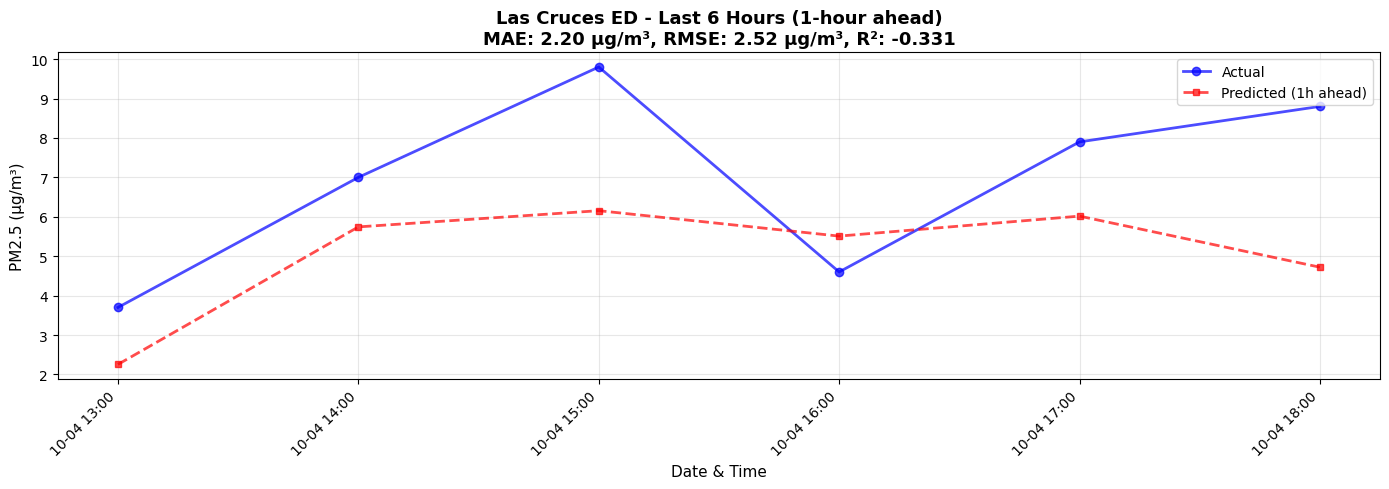

✓ Visualization complete

VISUALIZATION: FORECAST HORIZON


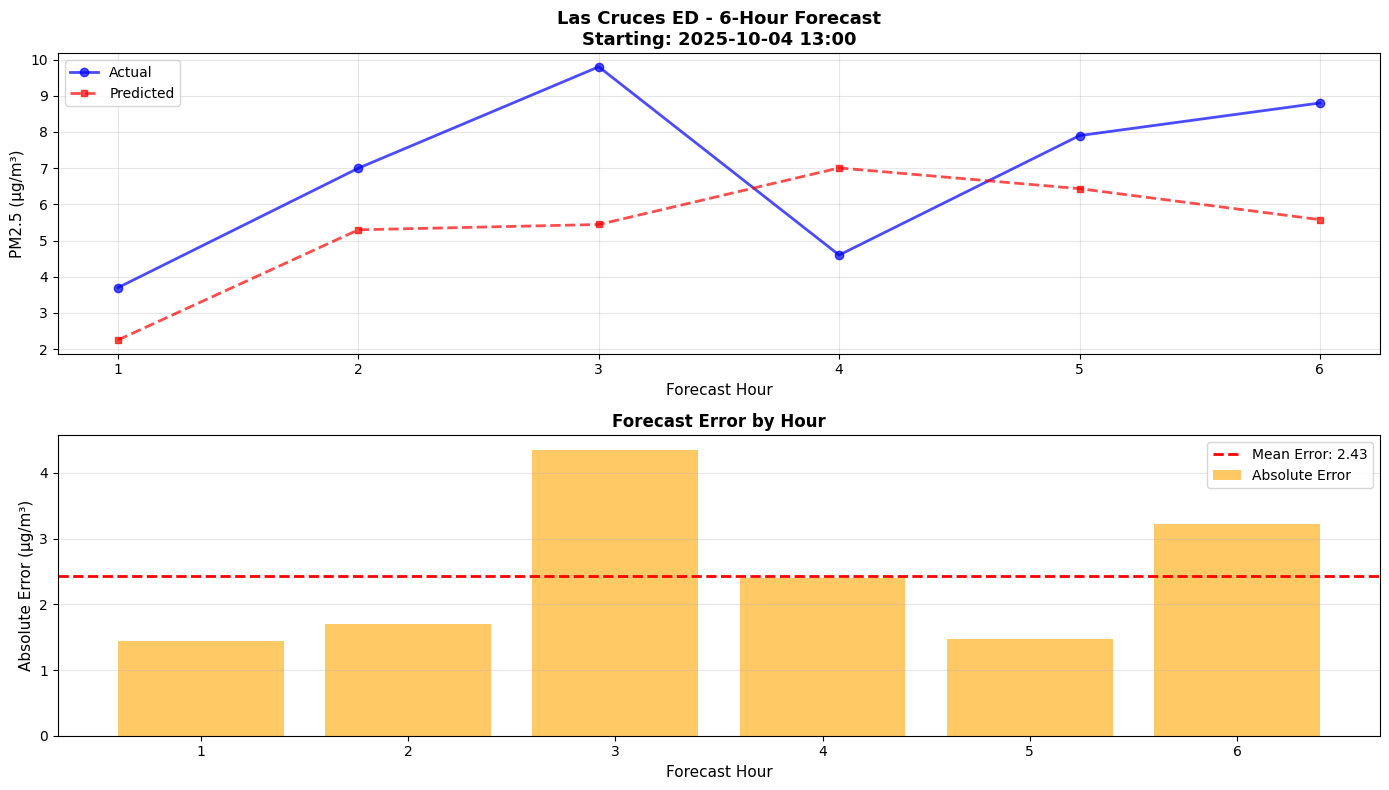

✓ Visualization complete

PREDICTING NEXT 24 HOURS

Using data up to: 2025-10-04 18:00

24-Hour Forecast:
--------------------------------------------------
Time                 Predicted PM2.5 (µg/m³)  
--------------------------------------------------
2025-10-04 19:00                     4.72
2025-10-04 20:00                     4.06
2025-10-04 21:00                     2.88
2025-10-04 22:00                     3.23
2025-10-04 23:00                     2.84
2025-10-05 00:00                     2.86
--------------------------------------------------
Average                              3.43
Min                                  2.84
Max                                  4.72

                            PIPELINE COMPLETE!

Model and feature columns saved to /content/drive/MyDrive/NASA/

To run:
1. Save your CSV data to a file
2. Update csv_path = 'your_file.csv'
3. Uncomment the main() call
4. Run the script


In [ ]:


# ============================================================================
# MAIN PIPELINE
# ============================================================================

def main(csv_path, lookback_hours=24, forecast_hours=24, test_hours=24):
    """
    Complete end-to-end forecasting pipeline.

    Args:
        csv_path: Path to CSV file
        lookback_hours: Hours of historical data to use (24 or 48 recommended)
        forecast_hours: Hours ahead to predict
        test_hours: Hours to reserve for testing
    """
    print("\n" + "="*80)
    print(" "*20 + "PM2.5 FORECASTING PIPELINE")
    print("="*80)

    # Step 1: Load data
    df, location_name = load_data(csv_path)

    # Step 2: Create features
    df_featured = create_features(df, lookback_hours, forecast_hours)

    # Step 3: Split data
    X_train, X_test, y_train, y_test, dates_test, feature_cols, target_cols = \
        split_data(df_featured, test_hours, forecast_hours)

    # Step 4: Train model
    model = train_model(X_train, y_train)

    # Step 5: Evaluate
    y_pred = evaluate_model(model, X_test, y_test)

    # Step 6: Visualize results
    visualize_last_24h(dates_test, y_test, y_pred, location_name)
    visualize_forecast_horizon(dates_test, y_test, y_pred, location_name)

    # Step 7: Predict next 24 hours
    future_times, forecast = predict_next_24h(model, df_featured, feature_cols)

    print("\n" + "="*80)
    print(" "*28 + "PIPELINE COMPLETE!")
    print("="*80)

    return model, df_featured, feature_cols, forecast


# ============================================================================
# USAGE
# ============================================================================

if __name__ == "__main__":
    # Example usage with 5 days of data (120 hours)
    csv_path = "/content/drive/MyDrive/NASA/OPENAQ_DATA/data5d.csv"  # Your 5-day CSV file
    save_path = "/content/drive/MyDrive/NASA/" # Specify save path

    # Run the complete pipeline
    model, df_featured, feature_cols, forecast = main(
        csv_path=csv_path,
        lookback_hours=12,   # Use 12 hours of history for features
        forecast_hours=6,   # Predict 6 hours ahead
        test_hours=6        # Use last 6 hours for testing
    )

    # Model is now trained and ready!
    # You can save it for production use:

    if model is not None:
        with open(f'{save_path}pm25_model.pkl', 'wb') as f: # Save to specified path
            pickle.dump(model, f)
        with open(f'{save_path}feature_cols.pkl', 'wb') as f: # Save to specified path
            pickle.dump(feature_cols, f)
        print(f"\nModel and feature columns saved to {save_path}")

    print("\nTo run:")
    print("1. Save your CSV data to a file")
    print("2. Update csv_path = 'your_file.csv'")
    print("3. Uncomment the main() call")
    print("4. Run the script")